# ¿Cuál es la mejor tarifa?

Trabajas como analista para el operador de telecomunicaciones Megaline. La empresa ofrece a sus clientes dos tarifas de prepago, Surf y Ultimate. El departamento comercial quiere saber cuál de las tarifas genera más ingresos para poder ajustar el presupuesto de publicidad.

Vas a realizar un análisis preliminar de las tarifas basado en una selección de clientes relativamente pequeña. Tendrás los datos de 500 clientes de Megaline: quiénes son los clientes, de dónde son, qué tarifa usan, así como la cantidad de llamadas que hicieron y los mensajes de texto que enviaron en 2018. Tu trabajo es analizar el comportamiento de los clientes y determinar qué tarifa de prepago genera más ingresos.

## Inicialización

En este ejercicio lo que buscamos lograr es obtener el plan que genera más ingresos actualmente Megaline para poderlo publicitar más. En este caso vamos a analisar el comportamiento de nuestros clientes para conocer cual de los dos planes nos genera más ingresos. Esto en base a el volumen % de clientes por plan, calculos de cargos extra por exceder limites, índice de cancelaciones.

In [1]:
import pandas as pd# Cargar todas las librerías
import numpy as np
from math import factorial
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import math

## Cargar datos

In [2]:
calls_data = pd.read_csv('/datasets/megaline_calls.csv')# Carga los archivos de datos en diferentes DataFrames
internet_data = pd.read_csv('/datasets/megaline_internet.csv')
messages_data = pd.read_csv('/datasets/megaline_messages.csv')
plans_data = pd.read_csv('/datasets/megaline_plans.csv')
users_data = pd.read_csv('/datasets/megaline_users.csv')

<div class="alert alert-block alert-success">
<b>Comentario del revisor:</b> <a class="tocSkip"></a>
    
Has realizado un excelente trabajo al importar los datos y las bibliotecas necesarias.

</div>

In [3]:
print(calls_data.info())
print()
print(internet_data.info())
print()
print(messages_data.info())
print()
print(plans_data.info())
print()
print(users_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Nul

## Preparar los datos

Los datos tienen en común la columna de user_id.
Para esto cambiaría el user_id a modo objeto, para poder hace búsquedas y relaciones entre las tablas de información.
Con esta columna podemos crear una relación entre las distintas tablas.
Esta columna nos va a permitir agregar información en otras bases de datos.
Por ejemplo, podriamos usar esta relación para conocer como se comportan los planes dentro de esta muestra aleatoria.
Podriamos buscar respuetas a:
- En general, lo usuarios de cual plan exceden más su límite mensual? 
- Densidad de población entre planes. 
- Qué plan genera más ingresos incluyendo cobros extras por exceder planes?

## Tarifas

In [4]:
# Imprime la información general/resumida sobre el DataFrame de las tarifa
print(plans_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes
None


In [5]:
display(plans_data) # Imprime una muestra de los datos para las tarifas

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


## Corregir datos

In [6]:
calls_data['user_id'] = calls_data['user_id'].astype('str')
messages_data['user_id'] = messages_data['user_id'].astype('str')
internet_data['user_id'] = internet_data['user_id'].astype('str')
users_data['user_id'] = users_data['user_id'].astype('str')

print(calls_data.info())
print()
print(messages_data.info())
print()
print(internet_data.info())
print()
print(users_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  object 
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), object(3)
memory usage: 4.2+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  object
 2   message_date  76051 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            10482

## Enriquecer los datos

Para enriquecer los datos voy a agregar a la tabla de usuarios: totales anuales por llamadas, por mensajes y de consumo de internet.
Con esta información sacaré un promedio mensual, para conocer en promedio cuanto gastan los usuarion por mes.
Luego teniendo esta información, sacaremos un total mensual de lo que gastan los usuarios considerando tarifa base del plan y cobros extras por exceder eñ límite del plan.
En este caso prefiero bajar la información a un promedio mensual, para poder hacer la comparación del consumo mensual vs. en plan establecido.

In [7]:
t_calls_per_user = calls_data.groupby(['user_id'])['duration'].sum()
display(t_calls_per_user) #Agrupamos por usuario llamadas totales al año

t_messages_per_user = messages_data.groupby(['user_id'])['id'].count()
display(t_messages_per_user) #Agrupamos por usuario mensajes totales al año

t_internet_per_user = internet_data.groupby(['user_id'])['mb_used'].sum()
print(t_internet_per_user) #Agrupamos por usuario MB usados anualmente

users_data_mer = users_data.merge(t_calls_per_user, left_on='user_id',right_on='user_id') #Agregamos llamadas totales a base de usuarios
users_data_merg = users_data_mer.merge(t_messages_per_user, left_on='user_id', right_on='user_id') #Agregamos mensajes totales a base de usuarios
users_data_merge = users_data_merg.merge(t_internet_per_user, left_on='user_id',right_on='user_id') #Agregamos MB usados totales a base de usuarios
users_data_merged=users_data_merge.rename(columns={'duration':'FY_total_calls','id':'FY_total_messages', 'mb_used':'FY_mb_used'}) #Renombramos columnas para poder identificar más rápido lo que nos muestran

users_data_merged['mthy_calls'] = users_data_merged['FY_total_calls'] / 12 #Agregar columna de consumo mensual en llamadas
users_data_merged['mthy_messages'] = users_data_merged['FY_total_messages'] / 12 #Agregar columna de consumo mensual en mensajes
users_data_merged['mthy_mb_used'] = users_data_merged['FY_mb_used'] / 12 #Agregar columna de consumo mensual en MB
users_data_merged['FY_gb_used'] = users_data_merged['FY_mb_used'] / 1024 #Agregamos el consumo de GBs anual
users_data_merged['mthy_gb_used'] = users_data_merged['FY_gb_used'] / 12

display(users_data_merged)

user_id
1000     116.83
1001    1640.46
1002     777.13
1003    1041.00
1004    2618.95
         ...   
1495    1666.41
1496    1376.21
1497     276.53
1498    3029.97
1499    1450.31
Name: duration, Length: 481, dtype: float64

user_id
1000     11
1001    207
1002     88
1003     50
1004    177
       ... 
1491    409
1492    108
1494    174
1496     65
1497     50
Name: id, Length: 402, dtype: int64

user_id
1000      1901.47
1001     80437.94
1002     40293.33
1003     27044.14
1004    156352.81
          ...    
1495     98890.96
1496     64268.64
1497     11106.55
1498    227525.13
1499     71350.23
Name: mb_used, Length: 489, dtype: float64


,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,FY_total_calls,FY_total_messages,FY_mb_used,mthy_calls,mthy_messages,mthy_mb_used,FY_gb_used,mthy_gb_used
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN,116.83,11,1901.47,9.735833,0.916667,158.455833,1.856904,0.154742
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN,1640.46,207,80437.94,136.705000,17.250000,6703.161667,78.552676,6.546056
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN,777.13,88,40293.33,64.760833,7.333333,3357.777500,39.348955,3.279080
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN,1041.00,50,27044.14,86.750000,4.166667,2253.678333,26.410293,2.200858
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN,2618.95,177,156352.81,218.245833,14.750000,13029.400833,152.688291,12.724024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388,1491,Terina,Jensen,22,"Grand Rapids-Kentwood, MI MSA",2018-04-27,surf,2018-09-18,3333.51,409,63050.67,277.792500,34.083333,5254.222500,61.572920,5.131077
389,1492,Elvie,Jones,63,"Portland-Vancouver-Hillsboro, OR-WA MSA",2018-03-07,surf,NaN,1003.46,108,40823.96,83.621667,9.000000,3401.996667,39.867148,3.322262
390,1494,Preston,Downs,70,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-04-19,surf,NaN,2672.66,174,91389.19,222.721667,14.500000,7615.765833,89.247256,7.437271
391,1496,Ariel,Shepherd,49,"New Orleans-Metairie, LA MSA",2018-02-20,surf,NaN,1376.21,65,64268.64,114.684167,5.416667,5355.720000,62.762344,5.230195


## Usuarios/as

In [8]:
users_data_merged.info()
# Imprime la información general/resumida sobre el DataFrame de usuarios

<class 'pandas.core.frame.DataFrame'>
Int64Index: 393 entries, 0 to 392
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   user_id            393 non-null    object 
 1   first_name         393 non-null    object 
 2   last_name          393 non-null    object 
 3   age                393 non-null    int64  
 4   city               393 non-null    object 
 5   reg_date           393 non-null    object 
 6   plan               393 non-null    object 
 7   churn_date         25 non-null     object 
 8   FY_total_calls     393 non-null    float64
 9   FY_total_messages  393 non-null    int64  
 10  FY_mb_used         393 non-null    float64
 11  mthy_calls         393 non-null    float64
 12  mthy_messages      393 non-null    float64
 13  mthy_mb_used       393 non-null    float64
 14  FY_gb_used         393 non-null    float64
 15  mthy_gb_used       393 non-null    float64
dtypes: float64(7), int64(2), o

In [9]:
print('Dataframe de usuarios con información del database original')
display(users_data.sample(10))
print()
print('Dataframe de usuarios con información extra de otras bases')
display(users_data_merged.sample(10))
# Imprime una muestra de datos para usuarios

Dataframe de usuarios con información del database original


,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
197,1197,Lon,Parker,56,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-11-05,surf,NaN
407,1407,Tristan,Daugherty,27,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-11-29,ultimate,NaN
112,1112,Amal,Pacheco,18,"Grand Rapids-Kentwood, MI MSA",2018-10-08,ultimate,NaN
168,1168,Shay,Weaver,58,"Milwaukee-Waukesha, WI MSA",2018-12-13,surf,NaN
100,1100,Aaron,Rowe,65,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-02-13,surf,NaN
199,1199,Antonetta,Finley,39,"San Antonio-New Braunfels, TX MSA",2018-08-01,ultimate,NaN
15,1015,Beata,Carpenter,26,"Pittsburgh, PA MSA",2018-12-05,surf,NaN
8,1008,Emely,Hoffman,53,"Orlando-Kissimmee-Sanford, FL MSA",2018-08-03,ultimate,NaN
385,1385,Nohemi,Erickson,52,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-01-19,surf,NaN
215,1215,Adelle,Knapp,70,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-07-01,surf,NaN



Dataframe de usuarios con información extra de otras bases


,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,FY_total_calls,FY_total_messages,FY_mb_used,mthy_calls,mthy_messages,mthy_mb_used,FY_gb_used,mthy_gb_used
196,1250,Milan,Sellers,57,"Houston-The Woodlands-Sugar Land, TX MSA",2018-04-03,ultimate,NaN,1423.96,201,28925.07,118.663333,16.750000,2410.422500,28.247139,2.353928
204,1258,Kai,Russell,39,"Chicago-Naperville-Elgin, IL-IN-WI MSA",2018-07-12,surf,NaN,361.60,277,117667.29,30.133333,23.083333,9805.607500,114.909463,9.575789
117,1151,Ralph,Monroe,21,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-03-20,surf,NaN,2367.74,260,69502.66,197.311667,21.666667,5791.888333,67.873691,5.656141
298,1379,Jarrett,Spencer,34,"Grand Rapids-Kentwood, MI MSA",2018-10-18,surf,NaN,1289.16,154,88703.89,107.430000,12.833333,7391.990833,86.624893,7.218741
63,1082,Dominic,Witt,64,"Memphis, TN-MS-AR MSA",2018-04-15,surf,NaN,5088.37,243,144900.36,424.030833,20.250000,12075.030000,141.504258,11.792021
221,1279,Neal,Duke,27,"Baton Rouge, LA MSA",2018-02-05,ultimate,NaN,1370.65,63,42010.81,114.220833,5.250000,3500.900833,41.026182,3.418848
146,1188,Ethelene,Brock,31,"Richmond, VA MSA",2018-01-10,ultimate,NaN,983.35,176,74130.37,81.945833,14.666667,6177.530833,72.392939,6.032745
158,1201,Jeanelle,Estrada,61,"Bridgeport-Stamford-Norwalk, CT MSA",2018-06-04,surf,NaN,2946.94,47,205644.03,245.578333,3.916667,17137.002500,200.824248,16.735354
162,1207,Samuel,Porter,63,"Omaha-Council Bluffs, NE-IA MSA",2018-12-22,surf,NaN,165.39,9,8278.51,13.782500,0.750000,689.875833,8.084482,0.673707
380,1481,Roni,Frye,32,"Urban Honolulu, HI MSA",2018-12-27,surf,NaN,33.19,3,1265.78,2.765833,0.250000,105.481667,1.236113,0.103009


### Corregir los datos

Los datos de este dataframe nos muestran información del usuario.
Aqui podemos conocer los datos demográficos del usuario al igual que el tipo de plan que maneja.
En este caso trabajamos una nuevas base de datos "users_data_merged", que ya contiene la columna de 'user_id' en formato object.
En esta sección cambiaremos los datos ausente de la columna 'churn_date', para que solo aparezcan los datos de los clientes que han cancelado y las fechas serán cambiadas a formato fecha.

In [10]:
users_data_merged['reg_date'] = pd.to_datetime(users_data_merged['reg_date'], format='%Y-%m-%d') #Convertimos el día de registro a formato fecha
users_data_merged['churn_date'] = pd.to_datetime(users_data_merged['churn_date'], format='%Y-%m-%d') #Convertimos el día de cancelación a formato fecha

display(users_data_merged.head(10))
print()
print(users_data_merged.info())

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,FY_total_calls,FY_total_messages,FY_mb_used,mthy_calls,mthy_messages,mthy_mb_used,FY_gb_used,mthy_gb_used
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaT,116.83,11,1901.47,9.735833,0.916667,158.455833,1.856904,0.154742
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,1640.46,207,80437.94,136.705000,17.250000,6703.161667,78.552676,6.546056
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaT,777.13,88,40293.33,64.760833,7.333333,3357.777500,39.348955,3.279080
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaT,1041.00,50,27044.14,86.750000,4.166667,2253.678333,26.410293,2.200858
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaT,2618.95,177,156352.81,218.245833,14.750000,13029.400833,152.688291,12.724024
5,1005,Livia,Shields,31,"Dallas-Fort Worth-Arlington, TX MSA",2018-11-29,surf,NaT,470.22,11,17140.17,39.185000,0.916667,1428.347500,16.738447,1.394871
6,1006,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",2018-11-27,ultimate,2018-12-18,64.11,154,34187.19,5.342500,12.833333,2848.932500,33.385928,2.782161
7,1007,Eusebio,Welch,42,"Grand Rapids-Kentwood, MI MSA",2018-07-11,surf,NaT,2484.15,255,143852.74,207.012500,21.250000,11987.728333,140.481191,11.706766
8,1008,Emely,Hoffman,53,"Orlando-Kissimmee-Sanford, FL MSA",2018-08-03,ultimate,NaT,1473.31,84,55473.04,122.775833,7.000000,4622.753333,54.172891,4.514408
9,1011,Halina,Henry,73,"Cleveland-Elyria, OH MSA",2018-01-18,ultimate,NaT,2744.87,371,131778.60,228.739167,30.916667,10981.550000,128.690039,10.724170



<class 'pandas.core.frame.DataFrame'>
Int64Index: 393 entries, 0 to 392
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            393 non-null    object        
 1   first_name         393 non-null    object        
 2   last_name          393 non-null    object        
 3   age                393 non-null    int64         
 4   city               393 non-null    object        
 5   reg_date           393 non-null    datetime64[ns]
 6   plan               393 non-null    object        
 7   churn_date         25 non-null     datetime64[ns]
 8   FY_total_calls     393 non-null    float64       
 9   FY_total_messages  393 non-null    int64         
 10  FY_mb_used         393 non-null    float64       
 11  mthy_calls         393 non-null    float64       
 12  mthy_messages      393 non-null    float64       
 13  mthy_mb_used       393 non-null    float64       
 14  FY_gb_use

In [11]:
users_data_merged = users_data_merged.fillna('') #Nos deshacemos de todos los campos con valores ausentes.

display(users_data_merged)

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,FY_total_calls,FY_total_messages,FY_mb_used,mthy_calls,mthy_messages,mthy_mb_used,FY_gb_used,mthy_gb_used
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,,116.83,11,1901.47,9.735833,0.916667,158.455833,1.856904,0.154742
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,,1640.46,207,80437.94,136.705000,17.250000,6703.161667,78.552676,6.546056
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,,777.13,88,40293.33,64.760833,7.333333,3357.777500,39.348955,3.279080
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,,1041.00,50,27044.14,86.750000,4.166667,2253.678333,26.410293,2.200858
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,,2618.95,177,156352.81,218.245833,14.750000,13029.400833,152.688291,12.724024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388,1491,Terina,Jensen,22,"Grand Rapids-Kentwood, MI MSA",2018-04-27,surf,2018-09-18 00:00:00,3333.51,409,63050.67,277.792500,34.083333,5254.222500,61.572920,5.131077
389,1492,Elvie,Jones,63,"Portland-Vancouver-Hillsboro, OR-WA MSA",2018-03-07,surf,,1003.46,108,40823.96,83.621667,9.000000,3401.996667,39.867148,3.322262
390,1494,Preston,Downs,70,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-04-19,surf,,2672.66,174,91389.19,222.721667,14.500000,7615.765833,89.247256,7.437271
391,1496,Ariel,Shepherd,49,"New Orleans-Metairie, LA MSA",2018-02-20,surf,,1376.21,65,64268.64,114.684167,5.416667,5355.720000,62.762344,5.230195


### Enriquecer los datos

In [12]:
#Ya se han agregado con prioridad los datos totales de llamadas, mensajes y megabytes.
#Además, se hizo un promedio mensual del consumo por usuario dentro de esta base.
#Columnas de la 8 a la 13 fueron agregadas previamente.
display(users_data_merged.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 393 entries, 0 to 392
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            393 non-null    object        
 1   first_name         393 non-null    object        
 2   last_name          393 non-null    object        
 3   age                393 non-null    int64         
 4   city               393 non-null    object        
 5   reg_date           393 non-null    datetime64[ns]
 6   plan               393 non-null    object        
 7   churn_date         393 non-null    object        
 8   FY_total_calls     393 non-null    float64       
 9   FY_total_messages  393 non-null    int64         
 10  FY_mb_used         393 non-null    float64       
 11  mthy_calls         393 non-null    float64       
 12  mthy_messages      393 non-null    float64       
 13  mthy_mb_used       393 non-null    float64       
 14  FY_gb_used

None

En el caso de churn_date, si no vemos ningún registro significa que el plan sigue activo.
churn_date nos dice los usuarios que han cancelado su plan.

## Llamadas

In [13]:
# Imprime la información general/resumida sobre el DataFrame de las llamadas
calls_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  object 
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), object(3)
memory usage: 4.2+ MB


In [14]:
# Imprime una muestra de datos para las llamadas
calls_data.sample(10)

,id,user_id,call_date,duration
45830,1166_13,1166,2018-10-21,0.81
105429,1371_413,1371,2018-12-22,0.00
137338,1498_268,1498,2018-04-11,14.06
77536,1277_612,1277,2018-06-13,7.84
50578,1182_172,1182,2018-12-23,1.33
135304,1491_129,1491,2018-06-22,16.90
88474,1324_528,1324,2018-09-12,11.87
79934,1286_679,1286,2018-12-31,4.57
47074,1171_105,1171,2018-04-28,5.31
119726,1417_342,1417,2018-11-24,17.75


### Corregir los datos

La columna de duración tiene los minutos con decimales.
Cada minuto se mide con 60 segundos, pero se puede observar que los minutos están representados por enteros y los segundos por decimales. 
Estos decimales superan los '.60' en varias ocasiones.
Creo necesario cambiar el tipo de valor a un entero, ya que los minutos no se miden con decimales.
También cambiar el tipo de dato de 'call_date' a fecha.
Esta nueva base corregida se puede usar para crear una base más precisa.
Usaré esta infomración a continuación para hacer una tabla parecida a 'users_data_merged'.

### Enriquecer los datos

In [15]:
calls_data['duration'] = calls_data['duration'].astype('int')
calls_data['call_date'] = pd.to_datetime(calls_data['call_date'], format='%Y-%m-%d')
display(calls_data)
print(calls_data.info())

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8
1,1000_145,1000,2018-12-27,13
2,1000_247,1000,2018-12-27,14
3,1000_309,1000,2018-12-28,5
4,1000_380,1000,2018-12-30,4
...,...,...,...,...
137730,1499_199,1499,2018-11-21,8
137731,1499_200,1499,2018-10-20,10
137732,1499_201,1499,2018-09-21,8
137733,1499_202,1499,2018-10-10,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         137735 non-null  object        
 1   user_id    137735 non-null  object        
 2   call_date  137735 non-null  datetime64[ns]
 3   duration   137735 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 4.2+ MB
None


## Mensajes

In [16]:
# Imprime la información general/resumida sobre el DataFrame de los mensajes
messages_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  object
 2   message_date  76051 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


In [17]:
# Imprime una muestra de datos para los mensajes
messages_data.sample(10)

,id,user_id,message_date
3445,1036_280,1036,2018-11-01
44560,1298_16,1298,2018-12-21
49923,1328_881,1328,2018-12-09
43132,1283_71,1283,2018-12-17
30266,1189_242,1189,2018-10-12
40901,1262_23,1262,2018-12-22
6941,1057_265,1057,2018-12-13
5266,1052_23,1052,2018-12-16
4529,1043_873,1043,2018-11-24
1691,1017_35,1017,2018-10-12


### Corregir los datos

En este caso la base de datos de mensajes ya paso por un cambio de valores en la columna 'user_id'.
Aí que no es necesario hacer otro cambio, el único cambio que se hará es cambiar la columna de 'message_date' a datetime.

### Enriquecer los datos

In [18]:
messages_data['message_date'] = pd.to_datetime(messages_data['message_date'], format='%Y-%m-%d')
display(messages_data)
print(messages_data.info())

,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26
...,...,...,...
76046,1497_526,1497,2018-12-24
76047,1497_536,1497,2018-12-24
76048,1497_547,1497,2018-12-31
76049,1497_558,1497,2018-12-24


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  object        
 1   user_id       76051 non-null  object        
 2   message_date  76051 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(2)
memory usage: 1.7+ MB
None


## Internet

In [19]:
# Imprime la información general/resumida sobre el DataFrame de internet
internet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  object 
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), object(3)
memory usage: 3.2+ MB


In [20]:
# Imprime una muestra de datos para el tráfico de internet
internet_data.sample(10)

,id,user_id,session_date,mb_used
26231,1122_186,1122,2018-07-29,38.67
11561,1056_228,1056,2018-10-31,178.43
5807,1031_494,1031,2018-09-06,279.71
13242,1062_212,1062,2018-11-25,202.91
88393,1408_112,1408,2018-09-18,1006.92
32818,1147_466,1147,2018-10-27,639.24
93723,1437_468,1437,2018-11-30,0.00
44757,1198_131,1198,2018-11-23,0.00
49503,1222_2,1222,2018-11-15,403.60
70293,1328_252,1328,2018-07-04,911.19


[Describe lo que ves y observas en la información general y en la muestra de datos impresa para el precio de datos anterior. ¿Hay algún problema (tipos de datos no adecuados, datos ausentes, etc.) que pudieran necesitar investigación y cambios adicionales? ¿Cómo se puede arreglar?]

### Corregir los datos

[Corrige los problemas obvios con los datos basándote en las observaciones iniciales.]

En este caso, cambiaría el formato de 'session_date' a datetime.
También cambiaría el formato de 'mb_used' a 'int', para redondear las cifras y poderla trabajarla de manera más sencilla.

### Enriquecer los datos

In [21]:
internet_data['mb_used'] = internet_data['mb_used'].astype('int')
internet_data['session_date'] = pd.to_datetime(internet_data['session_date'], format='%Y-%m-%d')
display(internet_data)
print(internet_data.info())

,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89
1,1000_204,1000,2018-12-31,0
2,1000_379,1000,2018-12-28,660
3,1000_413,1000,2018-12-26,270
4,1000_442,1000,2018-12-27,880
...,...,...,...,...
104820,1499_215,1499,2018-10-20,218
104821,1499_216,1499,2018-12-30,304
104822,1499_217,1499,2018-09-22,292
104823,1499_218,1499,2018-12-07,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  object        
 1   user_id       104825 non-null  object        
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 3.2+ MB
None


Finalmente, usaré el código de 'users_data_merged' para crear un nuevo dataframe.
Este dataframa contendrá la información actualizada de las mejoras y una nueva columna de GB usados, ya que los planes se miden pr GB.
Consideraremos que 1 GB = 1024 megabytes.
Estas dos bases 'users_data_merged' & 'users_data_mixed' tendrán ligeras variaciones en la data de los minutos en las llamadas y 'mb_used'. 
Ya que una considera los datos  en 'int' (users_data_mixed) y en otro en 'float'(users_data_merged).

In [22]:
t_calls_per_user_2 = calls_data.groupby(['user_id'])['duration'].sum()
#Agrupamos por usuario llamadas totales al año

t_messages_per_user_2 = messages_data.groupby(['user_id'])['id'].count()
#Agrupamos por usuario mensajes totales al año

t_internet_per_user_2 = internet_data.groupby(['user_id'])['mb_used'].sum()
#Agrupamos por usuario MB usados anualmente

users_data_mi = users_data.merge(t_calls_per_user_2, left_on='user_id',right_on='user_id') #Agregamos llamadas totales a base de usuarios
users_data_mix = users_data_mi.merge(t_messages_per_user_2, left_on='user_id', right_on='user_id') #Agregamos mensajes totales a base de usuarios
users_data_mixe = users_data_mix.merge(t_internet_per_user_2, left_on='user_id',right_on='user_id') #Agregamos MB usados totales a base de usuarios
users_data_mixed = users_data_mixe.rename(columns={'duration':'FY_total_calls','id':'FY_total_messages', 'mb_used':'FY_mb_used'}) #Renombramos columnas para poder identificar más rápido lo que nos muestran

users_data_mixed['mthy_calls'] = users_data_mixed['FY_total_calls'] / 12 #Agregar columna de consumo mensual en llamadas
users_data_mixed['mthy_messages'] = users_data_mixed['FY_total_messages'] / 12 #Agregar columna de consumo mensual en mensajes
users_data_mixed['mthy_mb_used'] = users_data_mixed['FY_mb_used'] / 12 #Agregar columna de consumo mensual en MB
users_data_mixed['FY_gb_used'] = users_data_mixed['FY_mb_used'] / 1024 #Agregamos el consumo de GBs anual
users_data_mixed['mthy_gb_used'] = users_data_mixed['FY_gb_used'] / 12 #Agregamos una columna con el consumo de GBs mensual

users_data_mixed = users_data_mixed.fillna('')

print('Calculo de los datos iniciales como "float"')
display(users_data_merged)
print()
print('Calculo de los datos iniciales como "int"')
display(users_data_mixed)

Calculo de los datos iniciales como "float"


,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,FY_total_calls,FY_total_messages,FY_mb_used,mthy_calls,mthy_messages,mthy_mb_used,FY_gb_used,mthy_gb_used
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,,116.83,11,1901.47,9.735833,0.916667,158.455833,1.856904,0.154742
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,,1640.46,207,80437.94,136.705000,17.250000,6703.161667,78.552676,6.546056
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,,777.13,88,40293.33,64.760833,7.333333,3357.777500,39.348955,3.279080
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,,1041.00,50,27044.14,86.750000,4.166667,2253.678333,26.410293,2.200858
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,,2618.95,177,156352.81,218.245833,14.750000,13029.400833,152.688291,12.724024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388,1491,Terina,Jensen,22,"Grand Rapids-Kentwood, MI MSA",2018-04-27,surf,2018-09-18 00:00:00,3333.51,409,63050.67,277.792500,34.083333,5254.222500,61.572920,5.131077
389,1492,Elvie,Jones,63,"Portland-Vancouver-Hillsboro, OR-WA MSA",2018-03-07,surf,,1003.46,108,40823.96,83.621667,9.000000,3401.996667,39.867148,3.322262
390,1494,Preston,Downs,70,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-04-19,surf,,2672.66,174,91389.19,222.721667,14.500000,7615.765833,89.247256,7.437271
391,1496,Ariel,Shepherd,49,"New Orleans-Metairie, LA MSA",2018-02-20,surf,,1376.21,65,64268.64,114.684167,5.416667,5355.720000,62.762344,5.230195



Calculo de los datos iniciales como "int"


,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,FY_total_calls,FY_total_messages,FY_mb_used,mthy_calls,mthy_messages,mthy_mb_used,FY_gb_used,mthy_gb_used
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,,108,11,1899,9.000000,0.916667,158.250000,1.854492,0.154541
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,,1533,207,80332,127.750000,17.250000,6694.333333,78.449219,6.537435
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,,735,88,40243,61.250000,7.333333,3353.583333,39.299805,3.274984
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,,987,50,27019,82.250000,4.166667,2251.583333,26.385742,2.198812
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,,2468,177,156152,205.666667,14.750000,13012.666667,152.492188,12.707682
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388,1491,Terina,Jensen,22,"Grand Rapids-Kentwood, MI MSA",2018-04-27,surf,2018-09-18,3152,409,62959,262.666667,34.083333,5246.583333,61.483398,5.123617
389,1492,Elvie,Jones,63,"Portland-Vancouver-Hillsboro, OR-WA MSA",2018-03-07,surf,,945,108,40775,78.750000,9.000000,3397.916667,39.819336,3.318278
390,1494,Preston,Downs,70,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-04-19,surf,,2517,174,91265,209.750000,14.500000,7605.416667,89.125977,7.427165
391,1496,Ariel,Shepherd,49,"New Orleans-Metairie, LA MSA",2018-02-20,surf,,1299,65,64187,108.250000,5.416667,5348.916667,62.682617,5.223551


## Estudiar las condiciones de las tarifas

En este caso, la empresa Megaline cuenta con dos tipos de planes de redes que puedes contratar.
- Surf: un plan más básico, tiene un límite menor para el uso de las redes. Es la opción más económica, aunque si te excedes de límite los cargos extras son más caros.
- Ultimate: es un plan más robusto, tiene un límite mayor para el uso de las redes. Es una opción más costosa, pero incluye una mayor cantidad de datos. En caso de tener cargos extras, estos salen más baratos.

In [23]:
# Imprime las condiciones de la tarifa y asegúrate de que te quedan claras
display(plans_data)

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


## Agregar datos por usuario

Para estos ejercicio usaré la base de datos 'users_data_merged'.
Ya que considero que se debe tener en cuenta los decimales hasta llegar a un resultado final.
Al presentar el valor final buscado el resultado puede ser redondeado en ese momento.

In [24]:
# Calcula el número de llamadas hechas por cada usuario al mes. Guarda el resultado.
mthy_calls_per_user = calls_data.groupby('user_id')['id'].count()

display(mthy_calls_per_user)

users_data_merged_2 = users_data_merged.merge(mthy_calls_per_user, left_on='user_id',right_on='user_id')
users_data_merged_2 = users_data_merged_2.rename(columns={'id':'calls_per_user'})

display(users_data_merged_2)

user_id
1000     16
1001    261
1002    113
1003    149
1004    370
       ... 
1495    253
1496    195
1497     54
1498    451
1499    204
Name: id, Length: 481, dtype: int64

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,FY_total_calls,FY_total_messages,FY_mb_used,mthy_calls,mthy_messages,mthy_mb_used,FY_gb_used,mthy_gb_used,calls_per_user
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,,116.83,11,1901.47,9.735833,0.916667,158.455833,1.856904,0.154742,16
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,,1640.46,207,80437.94,136.705000,17.250000,6703.161667,78.552676,6.546056,261
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,,777.13,88,40293.33,64.760833,7.333333,3357.777500,39.348955,3.279080,113
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,,1041.00,50,27044.14,86.750000,4.166667,2253.678333,26.410293,2.200858,149
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,,2618.95,177,156352.81,218.245833,14.750000,13029.400833,152.688291,12.724024,370
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388,1491,Terina,Jensen,22,"Grand Rapids-Kentwood, MI MSA",2018-04-27,surf,2018-09-18 00:00:00,3333.51,409,63050.67,277.792500,34.083333,5254.222500,61.572920,5.131077,462
389,1492,Elvie,Jones,63,"Portland-Vancouver-Hillsboro, OR-WA MSA",2018-03-07,surf,,1003.46,108,40823.96,83.621667,9.000000,3401.996667,39.867148,3.322262,164
390,1494,Preston,Downs,70,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-04-19,surf,,2672.66,174,91389.19,222.721667,14.500000,7615.765833,89.247256,7.437271,420
391,1496,Ariel,Shepherd,49,"New Orleans-Metairie, LA MSA",2018-02-20,surf,,1376.21,65,64268.64,114.684167,5.416667,5355.720000,62.762344,5.230195,195



<div class="alert alert-block alert-warning">

<b>Comentario revisor</b> <a class="tocSkip"></a>

Si bien es correcta la forma de agrupar para sacar la duración de las llamadas por cada ususario, para proximas ocasiones puedes hacer uso de la siguiente forma:
    
    pivot_calls = calls.pivot_table(index=['user_id', 'month'],
                                values=['duration'],
                                aggfunc=['sum','count']).reset_index()

</div>

In [25]:
# Calcula la cantidad de minutos usados por cada usuario al mes. Guarda el resultado.
mthy_mins_per_user = users_data_merged[['user_id','mthy_calls']]
print(mthy_mins_per_user)

    user_id  mthy_calls
0      1000    9.735833
1      1001  136.705000
2      1002   64.760833
3      1003   86.750000
4      1004  218.245833
..      ...         ...
388    1491  277.792500
389    1492   83.621667
390    1494  222.721667
391    1496  114.684167
392    1497   23.044167

[393 rows x 2 columns]


In [26]:
# Calcula el número de mensajes enviados por cada usuario al mes. Guarda el resultado.
mthy_msgs_per_user = users_data_merged[['user_id','mthy_messages']]
print(mthy_msgs_per_user)

    user_id  mthy_messages
0      1000       0.916667
1      1001      17.250000
2      1002       7.333333
3      1003       4.166667
4      1004      14.750000
..      ...            ...
388    1491      34.083333
389    1492       9.000000
390    1494      14.500000
391    1496       5.416667
392    1497       4.166667

[393 rows x 2 columns]


In [27]:
# Calcula el volumen del tráfico de Internet usado por cada usuario al mes. Guarda el resultado.
traffic_per_user = users_data_merged[['user_id','FY_mb_used','FY_gb_used','mthy_mb_used','mthy_gb_used']]
display(traffic_per_user)

,user_id,FY_mb_used,FY_gb_used,mthy_mb_used,mthy_gb_used
0,1000,1901.47,1.856904,158.455833,0.154742
1,1001,80437.94,78.552676,6703.161667,6.546056
2,1002,40293.33,39.348955,3357.777500,3.279080
3,1003,27044.14,26.410293,2253.678333,2.200858
4,1004,156352.81,152.688291,13029.400833,12.724024
...,...,...,...,...,...
388,1491,63050.67,61.572920,5254.222500,5.131077
389,1492,40823.96,39.867148,3401.996667,3.322262
390,1494,91389.19,89.247256,7615.765833,7.437271
391,1496,64268.64,62.762344,5355.720000,5.230195


[Junta los datos agregados en un DataFrame para que haya un registro que represente lo que consumió un usuario único en un mes determinado.]

In [28]:
users_data_merged_2['mthy_calls_per_user'] = users_data_merged_2['calls_per_user'] / 12

display(users_data_merged_2)

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,FY_total_calls,FY_total_messages,FY_mb_used,mthy_calls,mthy_messages,mthy_mb_used,FY_gb_used,mthy_gb_used,calls_per_user,mthy_calls_per_user
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,,116.83,11,1901.47,9.735833,0.916667,158.455833,1.856904,0.154742,16,1.333333
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,,1640.46,207,80437.94,136.705000,17.250000,6703.161667,78.552676,6.546056,261,21.750000
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,,777.13,88,40293.33,64.760833,7.333333,3357.777500,39.348955,3.279080,113,9.416667
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,,1041.00,50,27044.14,86.750000,4.166667,2253.678333,26.410293,2.200858,149,12.416667
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,,2618.95,177,156352.81,218.245833,14.750000,13029.400833,152.688291,12.724024,370,30.833333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388,1491,Terina,Jensen,22,"Grand Rapids-Kentwood, MI MSA",2018-04-27,surf,2018-09-18 00:00:00,3333.51,409,63050.67,277.792500,34.083333,5254.222500,61.572920,5.131077,462,38.500000
389,1492,Elvie,Jones,63,"Portland-Vancouver-Hillsboro, OR-WA MSA",2018-03-07,surf,,1003.46,108,40823.96,83.621667,9.000000,3401.996667,39.867148,3.322262,164,13.666667
390,1494,Preston,Downs,70,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-04-19,surf,,2672.66,174,91389.19,222.721667,14.500000,7615.765833,89.247256,7.437271,420,35.000000
391,1496,Ariel,Shepherd,49,"New Orleans-Metairie, LA MSA",2018-02-20,surf,,1376.21,65,64268.64,114.684167,5.416667,5355.720000,62.762344,5.230195,195,16.250000


In [29]:
# Fusiona los datos de llamadas, minutos, mensajes e Internet con base en user_id y month
users_data_merged_2 = users_data_merged_2.rename(columns={'FY_total_calls':'FY_total_mins_calls','mthy_calls':'mthy_mins_calls'})
display(users_data_merged_2[['user_id','mthy_mins_calls','mthy_calls_per_user','mthy_messages','mthy_mb_used','mthy_gb_used']])

,user_id,mthy_mins_calls,mthy_calls_per_user,mthy_messages,mthy_mb_used,mthy_gb_used
0,1000,9.735833,1.333333,0.916667,158.455833,0.154742
1,1001,136.705000,21.750000,17.250000,6703.161667,6.546056
2,1002,64.760833,9.416667,7.333333,3357.777500,3.279080
3,1003,86.750000,12.416667,4.166667,2253.678333,2.200858
4,1004,218.245833,30.833333,14.750000,13029.400833,12.724024
...,...,...,...,...,...,...
388,1491,277.792500,38.500000,34.083333,5254.222500,5.131077
389,1492,83.621667,13.666667,9.000000,3401.996667,3.322262
390,1494,222.721667,35.000000,14.500000,7615.765833,7.437271
391,1496,114.684167,16.250000,5.416667,5355.720000,5.230195


In [30]:
print(plans_data.info())
print()
print(users_data_merged_2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes
None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 393 entries, 0 to 392
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              393 non-null    object        
 1   first_name           393 n

In [31]:
# Añade la información de la tarifa
users_plans_data = users_data_merged_2.merge(plans_data, left_on='plan', right_on='plan_name')
users_plans_data = users_plans_data.drop('plan',axis='columns')

display(users_plans_data.info())
print()
display(users_plans_data.sample(5))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 393 entries, 0 to 392
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                393 non-null    object        
 1   first_name             393 non-null    object        
 2   last_name              393 non-null    object        
 3   age                    393 non-null    int64         
 4   city                   393 non-null    object        
 5   reg_date               393 non-null    datetime64[ns]
 6   churn_date             393 non-null    object        
 7   FY_total_mins_calls    393 non-null    float64       
 8   FY_total_messages      393 non-null    int64         
 9   FY_mb_used             393 non-null    float64       
 10  mthy_mins_calls        393 non-null    float64       
 11  mthy_messages          393 non-null    float64       
 12  mthy_mb_used           393 non-null    float64       
 13  FY_gb

None

,user_id,first_name,last_name,age,city,reg_date,churn_date,FY_total_mins_calls,FY_total_messages,FY_mb_used,...,calls_per_user,mthy_calls_per_user,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
122,1465,Arianna,Morrison,73,"Pittsburgh, PA MSA",2018-06-22,,4470.48,194,103575.17,...,650,54.166667,1000,30720,3000,70,7,0.01,0.01,ultimate
362,1434,Kai,Barr,18,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-03-06,,4184.15,482,139551.50,...,653,54.416667,50,15360,500,20,10,0.03,0.03,surf
145,1027,Georgeanna,Cardenas,38,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-06-26,,2014.79,78,92095.44,...,306,25.500000,50,15360,500,20,10,0.03,0.03,surf
154,1053,Piper,Espinoza,27,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-07-30,,2046.21,75,97132.25,...,296,24.666667,50,15360,500,20,10,0.03,0.03,surf
390,1492,Elvie,Jones,63,"Portland-Vancouver-Hillsboro, OR-WA MSA",2018-03-07,,1003.46,108,40823.96,...,164,13.666667,50,15360,500,20,10,0.03,0.03,surf


# Calcula el ingreso mensual para cada usuario

In [32]:
dif_mins = users_plans_data['mthy_mins_calls'] - users_plans_data['minutes_included']
dif_mins = np.where(dif_mins < 0, 0, dif_mins)
charge_dif_mins = dif_mins * users_plans_data['usd_per_minute']

dif_mb = users_plans_data['mthy_mb_used'] - users_plans_data['mb_per_month_included']
dif_mb = np.where(dif_mb < 0, 0, dif_mb)
dif_gb = dif_mb / 1024
charge_dif_gb = dif_gb * users_plans_data['usd_per_gb']

dif_msns = users_plans_data['mthy_messages'] - users_plans_data['messages_included']
dif_msns = np.where(dif_msns < 0, 0, dif_msns)
charge_dif_msns = dif_msns * users_plans_data['usd_per_message']

users_plans_data['charge_extra'] = charge_dif_mins + charge_dif_gb + charge_dif_msns
users_plans_data['total_charge'] = users_plans_data['charge_extra'] + users_plans_data['usd_monthly_pay']

display(users_plans_data)

,user_id,first_name,last_name,age,city,reg_date,churn_date,FY_total_mins_calls,FY_total_messages,FY_mb_used,...,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,charge_extra,total_charge
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,,116.83,11,1901.47,...,1000,30720,3000,70,7,0.01,0.01,ultimate,0.0,70.0
1,1006,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",2018-11-27,2018-12-18 00:00:00,64.11,154,34187.19,...,1000,30720,3000,70,7,0.01,0.01,ultimate,0.0,70.0
2,1008,Emely,Hoffman,53,"Orlando-Kissimmee-Sanford, FL MSA",2018-08-03,,1473.31,84,55473.04,...,1000,30720,3000,70,7,0.01,0.01,ultimate,0.0,70.0
3,1011,Halina,Henry,73,"Cleveland-Elyria, OH MSA",2018-01-18,,2744.87,371,131778.60,...,1000,30720,3000,70,7,0.01,0.01,ultimate,0.0,70.0
4,1013,Nicolas,Snider,50,"Knoxville, TN MSA",2018-12-01,,203.37,16,20113.92,...,1000,30720,3000,70,7,0.01,0.01,ultimate,0.0,70.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388,1489,Londa,Jenkins,72,"Detroit-Warren-Dearborn, MI MSA",2018-05-24,,1569.54,320,60995.75,...,50,15360,500,20,10,0.03,0.03,surf,0.0,20.0
389,1491,Terina,Jensen,22,"Grand Rapids-Kentwood, MI MSA",2018-04-27,2018-09-18 00:00:00,3333.51,409,63050.67,...,50,15360,500,20,10,0.03,0.03,surf,0.0,20.0
390,1492,Elvie,Jones,63,"Portland-Vancouver-Hillsboro, OR-WA MSA",2018-03-07,,1003.46,108,40823.96,...,50,15360,500,20,10,0.03,0.03,surf,0.0,20.0
391,1494,Preston,Downs,70,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-04-19,,2672.66,174,91389.19,...,50,15360,500,20,10,0.03,0.03,surf,0.0,20.0


## Estudia el comportamiento de usuario

### Llamadas

In [33]:
calls_data['call_date'] = pd.to_datetime(calls_data['call_date'], format='%Y-%m-%d')

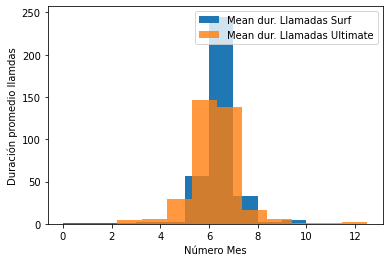

In [34]:
#Compara la duración promedio de llamadas por cada plan y por cada mes. Traza un gráfico de barras para visualizarla.
calls_data_gra = calls_data.merge(users_data, left_on='user_id', right_on='user_id')
calls_data_graph = pd.DataFrame(calls_data_gra.groupby(['plan','call_date'])['duration'].mean())
calls_data_surf = calls_data_graph.query("plan == 'surf'")
calls_data_ultimate = calls_data_graph.query("plan == 'ultimate'")
plt.hist(calls_data_surf, label='Mean dur. Llamadas Surf')
plt.hist(calls_data_ultimate, label='Mean dur. Llamadas Ultimate', alpha=0.8)
plt.legend(loc='upper right')
plt.ylabel('Duración promedio llamdas')
plt.xlabel('Número Mes')
plt.show()

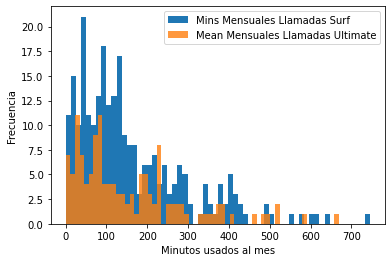

In [35]:
#Compara el número de minutos mensuales que necesitan los usuarios de cada plan. Traza un histograma.
mins_users_data_merged = users_plans_data.merge(calls_data, left_on='user_id', right_on='user_id')
mins_data_graph = pd.DataFrame(mins_users_data_merged.groupby(['mthy_mins_calls','plan_name'])['mthy_mins_calls'].mean())
mins_data_surf = mins_data_graph.query("plan_name == 'surf'")
mins_data_ultimate = mins_data_graph.query("plan_name == 'ultimate'")

mins_data_surf = pd.DataFrame(mins_data_surf)
mins_data_ultimate = pd.DataFrame(mins_data_ultimate)

plt.hist(mins_data_surf, label='Mins Mensuales Llamadas Surf', bins=60)
plt.hist(mins_data_ultimate, label='Mean Mensuales Llamadas Ultimate', bins=60, alpha=0.8)
plt.legend(loc='upper right')
plt.ylabel('Frecuencia')
plt.xlabel('Minutos usados al mes')
plt.show()

In [36]:
# Calcula la media y la varianza de la duración mensual de llamadas.
print('Media de Surf:', mins_data_surf['mthy_mins_calls'].mean())
print('Varianza de Surf:', np.var(mins_data_surf))
print()
print('Media de Ultimate:', mins_data_ultimate['mthy_mins_calls'].mean())
print('Varianza de Ultimate:', np.var(mins_data_ultimate))

Media de Surf: 159.29983460559805
Varianza de Surf: mthy_mins_calls    18277.504731
dtype: float64

Media de Ultimate: 154.0108524173028
Varianza de Ultimate: mthy_mins_calls    18259.631641
dtype: float64


Los usuarios del plan Surf pasan más tiempo en llamadas de teléfono que los usuarios de ultimate.

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='mthy_mins_calls'>

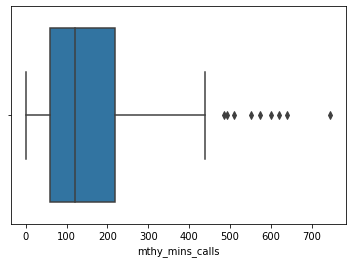

In [37]:
# Traza un diagrama de caja para visualizar la distribución de la duración mensual de llamadas
sns.boxplot(mins_data_surf['mthy_mins_calls'])

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='mthy_mins_calls'>

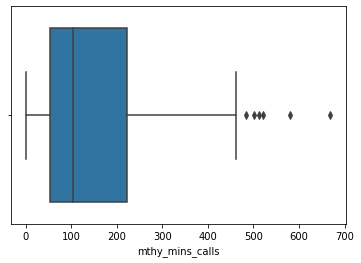

In [38]:
sns.boxplot(mins_data_ultimate['mthy_mins_calls'])

### Mensajes

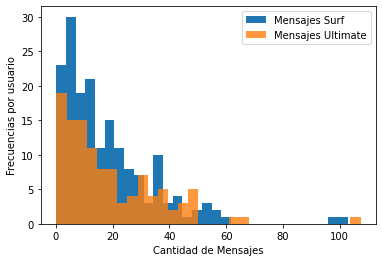

In [39]:
# Comprara el número de mensajes que tienden a enviar cada mes los usuarios de cada plan
msns_users_data_merged = users_plans_data.merge(messages_data, left_on='user_id', right_on='user_id')
msns_data_graph = pd.DataFrame(msns_users_data_merged.groupby(['plan_name','mthy_messages'])['mthy_messages'].mean())
msns_data_surf = msns_data_graph.query("plan_name == 'surf'")
msns_data_ultimate = msns_data_graph.query("plan_name == 'ultimate'")
plt.hist(msns_data_surf, label='Mensajes Surf', bins=30)
plt.hist(msns_data_ultimate, label='Mensajes Ultimate', bins=30, alpha=0.8)
plt.legend(loc='upper right')
plt.xlabel('Cantidad de Mensajes')
plt.ylabel('Frecuencias por usuario')
plt.show()

In [40]:
print('Media de Surf:', msns_data_surf['mthy_messages'].mean())
print('Varianza de Surf:', np.var(msns_data_surf))
print()
print('Media de Ultimate:', msns_data_ultimate['mthy_messages'].mean())
print('Varianza de Ultimate:', np.var(msns_data_ultimate))

Media de Surf: 17.935606060606062
Varianza de Surf: mthy_messages    273.577608
dtype: float64

Media de Ultimate: 18.65922619047618
Varianza de Ultimate: mthy_messages    302.297068
dtype: float64


Los usuarios con el plan de Surf suelen mandar mensajes en mayor cantidad que los usuarios de Ultimate.

### Internet

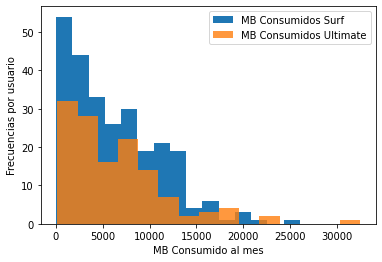

In [41]:
# Compara la cantidad de tráfico de Internet consumido por usuarios por plan
mb_users_data_merged = users_plans_data.merge(internet_data, left_on='user_id', right_on='user_id')
mb_data_graph = pd.DataFrame(mb_users_data_merged.groupby(['plan_name','user_id'])['mthy_mb_used'].mean())
mb_data_surf = mb_data_graph.query("plan_name == 'surf'")
mb_data_ultimate = mb_data_graph.query("plan_name == 'ultimate'")
plt.hist(mb_data_surf, label='MB Consumidos Surf', bins=15)
plt.hist(mb_data_ultimate, label='MB Consumidos Ultimate', alpha=0.8, bins=15)
plt.ylabel('Frecuencias por usuario')
plt.xlabel('MB Consumido al mes')
plt.legend(loc='upper right')
plt.show()

In [42]:
print('Media de Surf:', mb_data_surf['mthy_mb_used'].mean())
print('Varianza de Surf:', np.var(mb_data_surf))
print()
print('Media de Ultimate:', mb_data_ultimate['mthy_mb_used'].mean())
print('Varianza de Ultimate:', np.var(mb_data_ultimate))

Media de Surf: 6291.435788804072
Varianza de Surf: mthy_mb_used    2.325829e+07
dtype: float64

Media de Ultimate: 6378.834637404572
Varianza de Ultimate: mthy_mb_used    2.889932e+07
dtype: float64


Al igual que las llamadas y mensajes, los usuarios de Surf consumen más MB que los de Ultimate.
Se puede notar una tendencia mayor de consumo y usuarios para el plan Surf.

## Ingreso

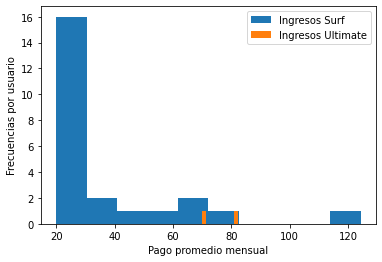

In [43]:
charge_data_graph = users_plans_data[['user_id','plan_name','total_charge']]
charge_data_graph_2 = pd.DataFrame(charge_data_graph.groupby(['plan_name','total_charge'])['total_charge'].mean())
charge_data_surf = charge_data_graph_2.query("plan_name == 'surf'")
charge_data_ultimate = charge_data_graph_2.query("plan_name == 'ultimate'")
plt.hist(charge_data_surf, label='Ingresos Surf')
plt.hist(charge_data_ultimate, label='Ingresos Ultimate')
plt.legend(loc='upper right')
plt.ylabel('Frecuencias por usuario')
plt.xlabel('Pago promedio mensual')
plt.show()

## Prueba las hipótesis estadísticas

Para esta prueba de hipótesis vamos a plantear como hipótesis nula que los usuarios pagan mensualmente el cargo de su plan, sin ningún cargo extra.
El promedio por plan debería ser igual al promedio del cargo mensual de todos los usuarios.
La hipótesis alternativa es que las usuarios del plan Surf gastan más en cargos extras que los del plan Ultimate, ya que el promedio de ingresos extras supera al plan de Ultimate.

In [44]:
# Prueba las hipótesis nula
alpha = 0.05
mthy_charges = users_plans_data[['plan_name','total_charge','usd_monthly_pay']]
mthy_charges_sur = mthy_charges.query("plan_name == 'surf'")
mthy_charges_ultimat = mthy_charges.query("plan_name == 'ultimate'")
mthy_charges_surf = mthy_charges_sur['total_charge']
mthy_charges_ultimate = mthy_charges_ultimat['total_charge']
int_value_surf = 20
int_value_ultimate = 70

results_surf = st.ttest_1samp(
    mthy_charges_surf, 
    int_value_surf)

results_ultimate = st.ttest_1samp(
    mthy_charges_ultimate, 
    int_value_ultimate)

print('valor p_surf: ', results_surf.pvalue)

print('valor p_ultimate: ', results_ultimate.pvalue)

if (results_surf.pvalue < alpha):
    print("Rechazamos la hipótesis nula")
else:
    print("No podemos rechazar la hipótesis nula")
    
if (results_ultimate.pvalue < alpha):
    print("Rechazamos la hipótesis nula")
else:
    print("No podemos rechazar la hipótesis nula")

valor p_surf:  0.005049825338193824
valor p_ultimate:  0.3191682370997443
Rechazamos la hipótesis nula
No podemos rechazar la hipótesis nula


Esta hipótesis nos da a entender que por lo general los usuarios de Surf pagan más cargos extras mensualmente que los usuarios de ultimate.
Los usuarios de ultimate por lo general, no consumen más de lo que está dentro de su plan.

En este caso crearemos uns hipótesis basada en el consumo de los usuarios que se encuentran en NY y NJ, y comparar su comportamiento con el resto de los usuarios a nivel total.
La hipótesis nula esque los usuarios tienen los mismos comportamientos de consumo que el resto de los usuarios totales de los planes de telefonía.
Usaremos el mismo valor de alpha ya definido previamente.

In [58]:
mthy_charges_N = users_plans_data[['plan_name','total_charge','city']]
mthy_charges_sur_N = mthy_charges_N.query("plan_name == 'surf'")
mthy_charges_ultimat_N = mthy_charges_N.query("plan_name == 'ultimate'")
mthy_charges_surf_N = mthy_charges_sur_N[mthy_charges_sur_N['city'].str.contains("NY|NJ")]['total_charge']
mthy_charges_ultimate_N = mthy_charges_ultimat_N[mthy_charges_ultimat_N['city'].str.contains("NY|NJ")]['total_charge']
results_surf_N = st.ttest_ind(mthy_charges_surf_N, mthy_charges_surf,equal_var = False)
results_ultimate_N = st.ttest_ind(mthy_charges_ultimate_N, mthy_charges_ultimate,equal_var = False)

print('valor p_surf_N: ', results_surf_N.pvalue)

print('valor p_ultimate_N: ', results_ultimate_N.pvalue)

if (results_surf_N.pvalue < alpha):
    print("Rechazamos la hipótesis nula")
else:
    print("No podemos rechazar la hipótesis nula")
    
if (results_ultimate_N.pvalue < alpha):
    print("Rechazamos la hipótesis nula")
else:
    print("No podemos rechazar la hipótesis nula")

valor p_surf_N:  0.39135765025552194
valor p_ultimate_N:  0.4249805508464456
No podemos rechazar la hipótesis nula
No podemos rechazar la hipótesis nula


En este caso no podemos rechazar la hipótesis nula.
Ya que los usuarios de NY y NJ tienen comportamientos muy similares a el resto de la población de usuarios.
La distribución es cercana a a la distribucón total como la que tenemos para todos los usuarios de Surf y Ultimate.

# Conclusión
Las usuarios de surf tienden a consumir más mensajes, llamadas y MG al mes.
Esto lo podemos saber al desmenuzar los consumos por estas categorías y hacer comparaciones de los consumos por plan.
Esto nos dá a entender que aunque compren un plan más barato, lo terminan excediendo y por ende pagan más cargos extra los usuarios de surf.
Es necesario decomponer los consumos por categorías y población.
Para poder validar si el consumo es mayor en todas las categorías o solo una de ellas.
En esta caso, en promedio todos los usuarios de surf sueles conumir más servicios dentro de su plan.
En sí nos sale más coveniente que sigan teniendo cargos extra, ya que deja un ingreso mayor a la compañía.